In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn; seaborn.set()
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from collections import Counter
import re
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import random
from statsmodels.tsa.stattools import adfuller

# loading data + EDA

In [2]:
print(os.getcwd(),'\n')
print(os.listdir())

C:\Users\Dilet\Desktop\Unsupervised\BitCoinPrice 

['.ipynb_checkpoints', 'bitcoin-price-prediction-with-arima.ipynb', 'bitcoin_price_test.csv', 'bitcoin_price_train.csv']


In [2]:
data = pd.read_csv("bitcoin_price_train.csv", index_col = 'Date')
print(data.head(5))
print(data.tail(5),'\n')
print(data.dtypes)
data.describe()

                 Open     High      Low    Close         Volume  \
Date                                                              
Jul 31, 2017  2763.24  2889.62  2720.61  2875.34    860,575,000   
Jul 30, 2017  2724.39  2758.53  2644.85  2757.18    705,943,000   
Jul 29, 2017  2807.02  2808.76  2692.80  2726.45    803,746,000   
Jul 28, 2017  2679.73  2897.45  2679.73  2809.01  1,380,100,000   
Jul 27, 2017  2538.71  2693.32  2529.34  2671.78    789,104,000   

                  Market Cap  
Date                          
Jul 31, 2017  45,535,800,000  
Jul 30, 2017  44,890,700,000  
Jul 29, 2017  46,246,700,000  
Jul 28, 2017  44,144,400,000  
Jul 27, 2017  41,816,500,000  
                Open    High     Low   Close Volume     Market Cap
Date                                                              
May 02, 2013  116.38  125.60   92.28  105.21      -  1,292,190,000
May 01, 2013  139.00  139.89  107.72  116.99      -  1,542,820,000
Apr 30, 2013  144.00  146.93  134.05  139.00 

,Open,High,Low,Close
count,1556.000000,1556.000000,1556.000000,1556.000000
mean,582.625328,597.992847,567.851446,584.239396
std,523.137312,542.992855,505.877401,525.904442
min,68.500000,74.560000,65.530000,68.430000
25%,254.287500,260.327500,248.835000,254.320000
50%,438.600000,447.560000,430.570000,438.855000
75%,662.437500,674.525000,646.735000,663.402500
max,2953.220000,2999.910000,2840.530000,2958.110000


load test

In [3]:
test = pd.read_csv('bitcoin_price_test.csv', index_col ='Date')
test.index = pd.to_datetime(test.index)
test = test['Close']
test = test.sort_index()
test

Date
2017-08-01    2718.26
2017-08-02    2710.67
2017-08-03    2804.73
2017-08-04    2895.89
2017-08-05    3252.91
2017-08-06    3213.94
2017-08-07    3378.94
Name: Close, dtype: float64

Let's convert date index in a right format

In [4]:
data.index = pd.to_datetime(data.index)

Now sort the dataset from oldest - recent 

In [137]:
data = data.sort_index()
data.head()

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2013-04-28,135.30,135.98,132.10,134.21,-,"1,500,520,000"
2013-04-29,134.44,147.49,134.00,144.54,-,"1,491,160,000"
2013-04-30,144.00,146.93,134.05,139.00,-,"1,597,780,000"
2013-05-01,139.00,139.89,107.72,116.99,-,"1,542,820,000"
2013-05-02,116.38,125.60,92.28,105.21,-,"1,292,190,000"


Text(0, 0.5, 'DAily Bitcoin price')

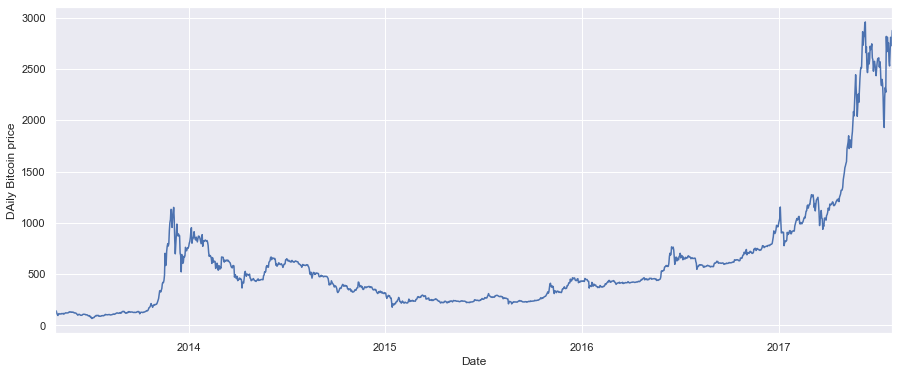

In [5]:
data['Close'].plot()
plt.ylabel("DAily Bitcoin price")

With the  model we will try to predict the Closing price of Bitcoin, so let's just use **Close** for now

In [6]:
ts = data['Close']
# ts = timeseries :)

- Make some data exploration
- plot by:
    * week
    * year
    * weekday
    * dayofyear


# Testing the Stationarity
The Augmented Dicky Fuller test is a type of statistical test called a unit root test.
The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend.

1. Null Hypothesis (H0): Null hypothesis of the test is that the time series can be represented by a unit root that is not stationary.
2. Alternative Hypothesis (H1): Alternative Hypothesis of the test is that the time series is stationary.

1. p value > 0.05: Accepts the Null Hypothesis (H0), the data has a unit root and is non-stationary.
2. p value < = 0.05: Rejects the Null Hypothesis (H0), the data is stationary.

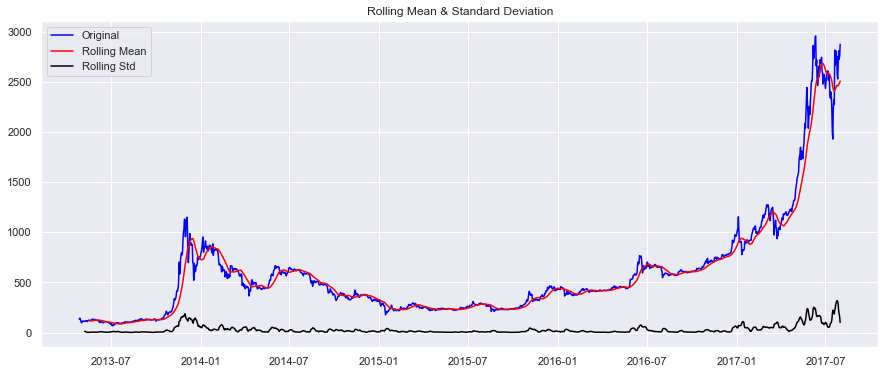

ADF Stastistic: 2.535589
p-value: 0.999060
The graph is non stationery
Critical values:
	1%: -3.435 
	5%: -2.863 
	10%: -2.568 


In [140]:
def test_stationarity(x):


    #Determing rolling statistics
    rolmean = x.rolling(window=22,center=False).mean()

    rolstd = x.rolling(window=12,center=False).std()
    
    #Plot rolling statistics:
    orig = plt.plot(x, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey Fuller test    
    result=adfuller(x)
    print('ADF Stastistic: %f'%result[0])
    print('p-value: %f'%result[1])
    pvalue=result[1]
    for key,value in result[4].items():
         if result[0]>value:
            print("The graph is non stationery")
            break
         else:
            print("The graph is stationery")
            break;
    print('Critical values:')
    for key,value in result[4].items():
        print('\t%s: %.3f ' % (key, value))
              
test_stationarity(ts)

Since the p value is greater than 0.05 the time series is non stationary.. So now we use transformations to make the series stationary.
#### Stationary
### Stationary
## Stationary
# Stationary

# Transforming the data  

## Log Transforming the series
Log transformation is used to unskew highly skewed data. Thus helping in forecasting process.

NameError: name 'test_stationarity' is not defined

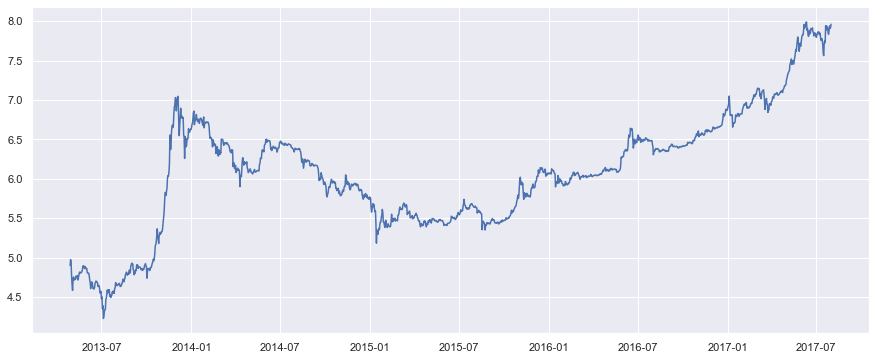

In [7]:
ts_log = np.log(ts)
plt.plot(ts_log)

test_stationarity(ts_log)

The series is still non stationary as p value is still greater than 0.05 so we need to make further transformations. So let’s go ahead with differencing.

## Remove trend and seasonality with differencing

In case of differencing to make the time series stationary the current value is subtracted with the previous values. Due to this the mean is stabilized and hence the chances of stationarity of time series are increased

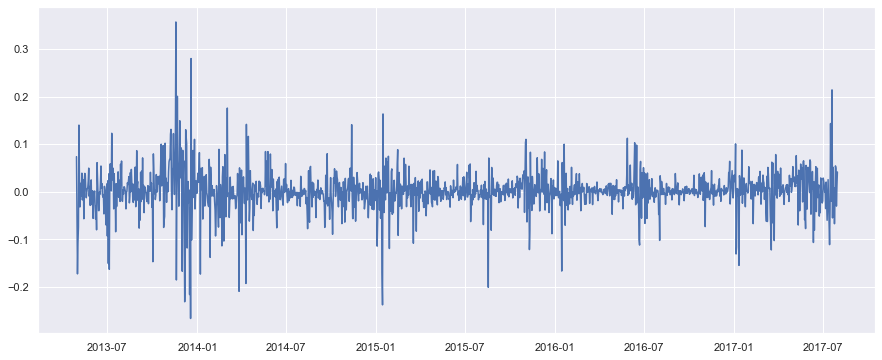

In [145]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)
plt.show()

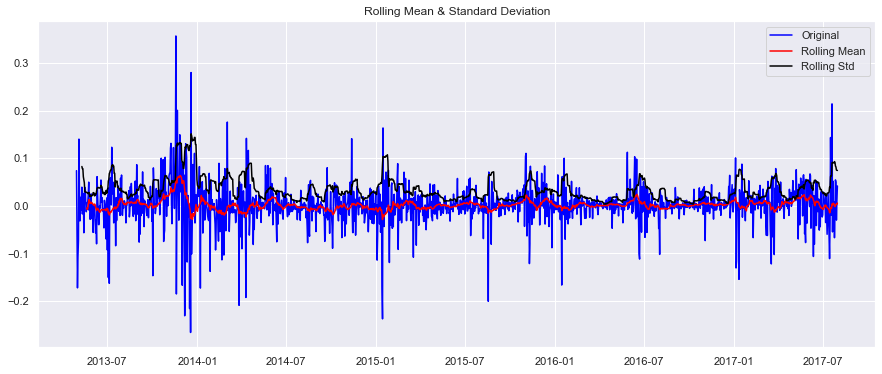

ADF Stastistic: -7.285034
p-value: 0.000000
The graph is stationery
Critical values:
	1%: -3.435 
	5%: -2.863 
	10%: -2.568 


In [147]:
test_stationarity(ts_log_diff.dropna())

Finally stationarity
#### Stationary
### Stationary
## Stationary
# Stationary

Why i'm dropping na? 


In [159]:
ts_log_diff.dropna(inplace=True)

# Auto Regressive Model


Auto regressive model is a time series forecasting model where current values are dependent on past values.
**Applause**

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


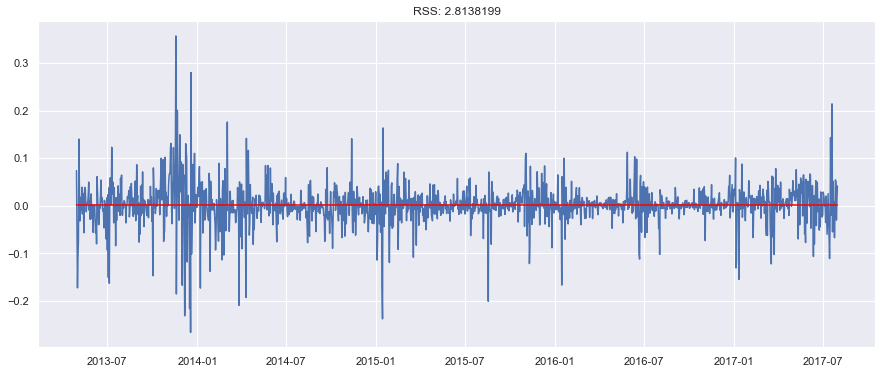

In [161]:
# follow lag
model = ARIMA(ts_log, order=(1,1,0))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.7f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))
plt.show()

# Moving Average Model

In moving average model the series is dependent on past error terms. **This hurt**

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


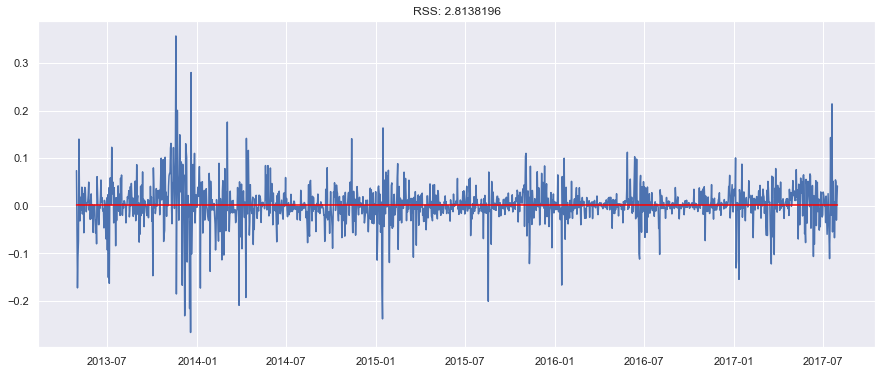

In [162]:
# follow error
model = ARIMA(ts_log, order=(0,1,1))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.7f'% sum((results_MA.fittedvalues-ts_log_diff)**2))
plt.show()

# Auto Regressive Integrated Moving Average Model 

It is a combination of both AR and MA models. It makes the time series stationary by itself through the process of differencing. Therefore differencing need not be done explicitly for ARIMA model. **Diabolic mix**

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


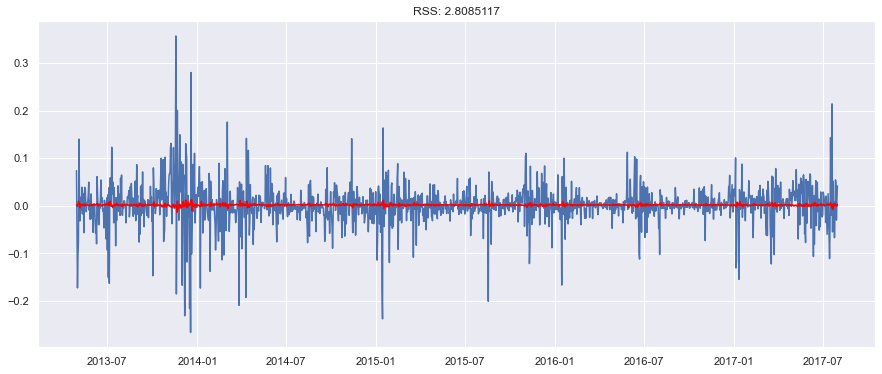

In [163]:
model = ARIMA(ts_log, order=(2,1,0))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.7f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))
plt.show()

Thus we see that the RSS (Residual Sum of Squares) error is minimum for ARIMA model. Therefore ARIMA model is the best among the three models because of use of dependence on both lagged values and error terms. Therefore it is further used to calculate the mean square error.
For every value in the test test we apply an ARIMA model and then the error is calculated and then after iterating over all values in the test set the mean error between predicted and expected value is calculated.

In [165]:
ts_log_test = np.log(test)

Printing Predicted vs Expected Values...


predicted = 2879.720912,   expected = 2718.260000,   error = 5.939863  %
predicted = 2719.065126,   expected = 2710.670000,   error = 0.309707  %
predicted = 2722.844290,   expected = 2804.730000,   error = 2.919558  %
predicted = 2810.621051,   expected = 2895.890000,   error = 2.944482  %
predicted = 2897.319469,   expected = 3252.910000,   error = 10.931459  %
predicted = 3255.223400,   expected = 3213.940000,   error = 1.284511  %
predicted = 3204.658013,   expected = 3378.940000,   error = 5.157889  %

 Mean Error in Predicting Test Case Articles : 4.212495  %


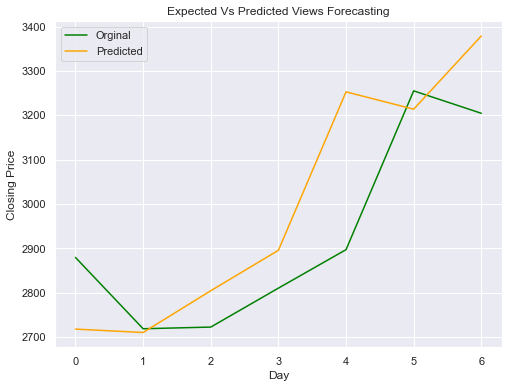

In [167]:
history = [x for x in ts_log]
predictions = list()
originals = list()
error_list = list()

print('Printing Predicted vs Expected Values...')
print('\n')
# We go over each value in the test set and then apply ARIMA model and calculate the predicted value. We have the expected value in the test set therefore we calculate the error between predicted and expected value 
for t in range(len(ts_log_test)):
    model = ARIMA(history, order=(2, 1, 0))
    model_fit = model.fit(disp=-1)
    
    output = model_fit.forecast()
    
    pred_value = output[0]
    
        
    original_value = ts_log_test[t]
    history.append(original_value)
    
    pred_value = np.exp(pred_value)
    
    
    original_value = np.exp(original_value)
    
    # Calculating the error
    error = ((abs(pred_value - original_value)) / original_value) * 100
    error_list.append(error)
    print('predicted = %f,   expected = %f,   error = %f ' % (pred_value, original_value, error), '%')
    
    predictions.append(float(pred_value))
    originals.append(float(original_value))
    
# After iterating over whole test set the overall mean error is calculated.   
print('\n Mean Error in Predicting Test Case Articles : %f ' % (sum(error_list)/float(len(error_list))), '%')
plt.figure(figsize=(8, 6))
test_day = [t
           for t in range(len(ts_log_test))]
labels={'Orginal','Predicted'}
plt.plot(test_day, predictions, color= 'green')
plt.plot(test_day, originals, color = 'orange')
plt.title('Expected Vs Predicted Views Forecasting')
plt.xlabel('Day')
plt.ylabel('Closing Price')
plt.legend(labels)
plt.show()

Therefore the original and predicted time series is plotted with mean error of 4.21%.... but what we can do to make it "better"? The solution is closer than you might think.





p.s. Look down

## Make test bigger

In [55]:
add_test=ts[-200:]
ts.drop(add_test.index, inplace=True)
test = pd.concat([add_test,test])

## Something useful for later...

In [9]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)


Seq length is how big we want to make our window. For example taking an input of our data sequence if we choose a window of 7, we try to predict from the 7 previous observations the observation we consider as input. 
Why? Because it is assumed that the previous observations can give you information about the observation you consider as input.
A big turn of phrase.

In [10]:
def call_seed():
    random_seed=1234
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)

    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

only to make the results reproducible. Trust me

# RNN and Pytorch Time!

### ERRATA CORRIGE: 

#### first standardization using sklearn

In [56]:
#
sc = MinMaxScaler()
sc.fit(ts.values.reshape(-1,1))
training_data = sc.transform(ts.values.reshape(-1, 1))
test_data = sc.transform(test.values.reshape(-1,1))

seq_length = 7
x_train, y_train = sliding_windows(training_data, seq_length)
x_test, y_test = sliding_windows(test_data, 2)


trainX = Variable(torch.Tensor(x_train))
trainY = Variable(torch.Tensor(y_train))
testX = Variable(torch.Tensor(x_test))
testY = Variable(torch.Tensor(y_test))



#### second standardization using raw formula : $\frac{x - x.min()}{(x.max() - x.min())}$

In [65]:
#

training_data = (ts.values.reshape(-1, 1) - ts.min()) / (ts.max() -ts.min())
test_data = (test.values.reshape(-1,1) - ts.min()) / (ts.max() -ts.min())

seq_length = 7
x_train, y_train = sliding_windows(training_data, seq_length)
x_test, y_test = sliding_windows(test_data, 2)


trainX = Variable(torch.Tensor(x_train))
trainY = Variable(torch.Tensor(y_train))
testX = Variable(torch.Tensor(x_test))
testY = Variable(torch.Tensor(y_test))



In [66]:
class RNN(nn.Module):
    def __init__(self, inpute_size, hidden_size, num_layers, dropout_prob):
        super(RNN, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # RNN layers
        self.rnn = nn.RNN(
            input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, 1) #1 outputdim

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

In [67]:
call_seed()
train_losses = []
val_losses = []
num_epochs = 2000
learning_rate = 0.001

input_size = 1
hidden_size = 2
num_layers = 2


rnn = RNN(input_size, hidden_size, num_layers,0.1)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = rnn(trainX)
    optimizer.zero_grad() #gradiente azzerato sennò usi quello dell'iterazione prima.
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    train_losses.append(loss.item())
    
    loss.backward() #backpropagation
    
    optimizer.step() #applica il gradiente 
    with torch.no_grad(): #facciamo un validation sul test, ma qui la rete NON impara!
        outputs_val = rnn(testX)
        loss_val = criterion(outputs_val,testY)
        val_losses.append(loss_val.item())
    if epoch %100 == 0 :
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
        print("Epoch: %d, loss_val: %1.5f" % (epoch, loss_val.item()))

Epoch: 0, loss: 0.37670
Epoch: 0, loss_val: 0.44914
Epoch: 100, loss: 0.10586
Epoch: 100, loss_val: 0.14362
Epoch: 200, loss: 0.04499
Epoch: 200, loss_val: 0.05215
Epoch: 300, loss: 0.03877
Epoch: 300, loss_val: 0.03593
Epoch: 400, loss: 0.03253
Epoch: 400, loss_val: 0.03244
Epoch: 500, loss: 0.00892
Epoch: 500, loss_val: 0.02495
Epoch: 600, loss: 0.00301
Epoch: 600, loss_val: 0.01915
Epoch: 700, loss: 0.00325
Epoch: 700, loss_val: 0.01747
Epoch: 800, loss: 0.00285
Epoch: 800, loss_val: 0.01672
Epoch: 900, loss: 0.00266
Epoch: 900, loss_val: 0.01661
Epoch: 1000, loss: 0.00317
Epoch: 1000, loss_val: 0.01645
Epoch: 1100, loss: 0.00243
Epoch: 1100, loss_val: 0.01529
Epoch: 1200, loss: 0.00195
Epoch: 1200, loss_val: 0.01557
Epoch: 1300, loss: 0.00241
Epoch: 1300, loss_val: 0.01494
Epoch: 1400, loss: 0.00210
Epoch: 1400, loss_val: 0.01495
Epoch: 1500, loss: 0.00267
Epoch: 1500, loss_val: 0.01404
Epoch: 1600, loss: 0.00170
Epoch: 1600, loss_val: 0.01456
Epoch: 1700, loss: 0.00191
Epoch: 1700

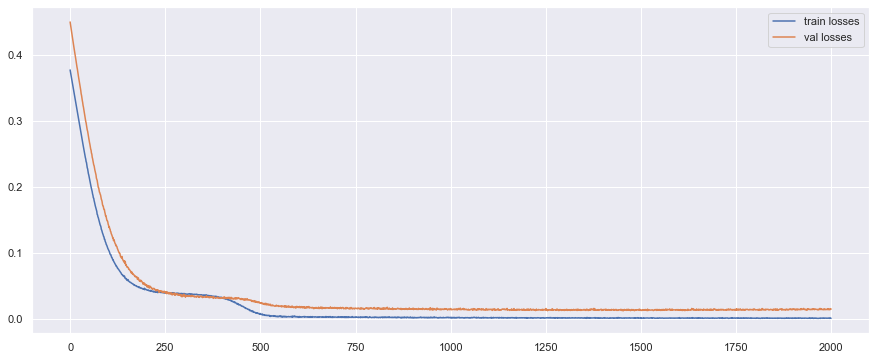

In [68]:
plt.plot(train_losses,label='train losses')
plt.plot(val_losses, label = 'val losses')
plt.legend()
plt.show()

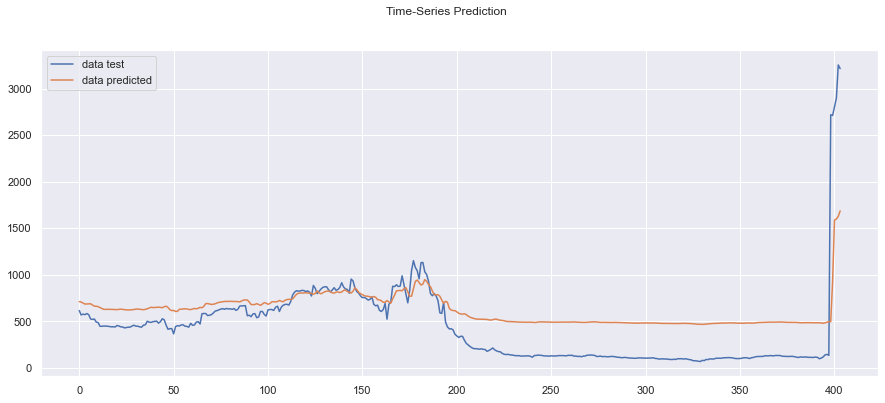

In [69]:
rnn.eval()
test_predict = rnn(testX)

data_predict = test_predict.data.numpy()
dataY_plot = testY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.plot(dataY_plot, label = 'data test')
plt.plot(data_predict, label = 'data predicted')
plt.suptitle('Time-Series Prediction')
plt.legend()
plt.show()
# plt.axvline(x=200, c='r', linestyle='--')

# LSTM


In [76]:
class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [77]:
call_seed()
train_losses = []
val_losses = []
num_epochs = 2000
learning_rate = 0.001

input_size = 1
hidden_size = 2
num_layers = 1


lstm = LSTM(input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad() #gradiente azzerato sennò usi quello dell'iterazione prima.
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    train_losses.append(loss.item())
    
    loss.backward() #backpropagation
    
    optimizer.step() #applica il gradiente 
    with torch.no_grad(): #facciamo un validation sul test, ma qui la rete NON impara!
        outputs_val = lstm(testX)
        loss_val = criterion(outputs_val,testY)
        val_losses.append(loss_val.item())
    if epoch %100 == 0 :
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
        print("Epoch: %d, loss_val: %1.5f" % (epoch, loss_val.item()))

Epoch: 0, loss: 0.04143
Epoch: 0, loss_val: 0.02286
Epoch: 100, loss: 0.02743
Epoch: 100, loss_val: 0.02188
Epoch: 200, loss: 0.00635
Epoch: 200, loss_val: 0.01673
Epoch: 300, loss: 0.00102
Epoch: 300, loss_val: 0.01478
Epoch: 400, loss: 0.00089
Epoch: 400, loss_val: 0.01442
Epoch: 500, loss: 0.00078
Epoch: 500, loss_val: 0.01369
Epoch: 600, loss: 0.00070
Epoch: 600, loss_val: 0.01297
Epoch: 700, loss: 0.00062
Epoch: 700, loss_val: 0.01228
Epoch: 800, loss: 0.00056
Epoch: 800, loss_val: 0.01164
Epoch: 900, loss: 0.00052
Epoch: 900, loss_val: 0.01105
Epoch: 1000, loss: 0.00047
Epoch: 1000, loss_val: 0.01050
Epoch: 1100, loss: 0.00044
Epoch: 1100, loss_val: 0.01000
Epoch: 1200, loss: 0.00041
Epoch: 1200, loss_val: 0.00954
Epoch: 1300, loss: 0.00039
Epoch: 1300, loss_val: 0.00913
Epoch: 1400, loss: 0.00037
Epoch: 1400, loss_val: 0.00875
Epoch: 1500, loss: 0.00035
Epoch: 1500, loss_val: 0.00840
Epoch: 1600, loss: 0.00033
Epoch: 1600, loss_val: 0.00808
Epoch: 1700, loss: 0.00032
Epoch: 1700

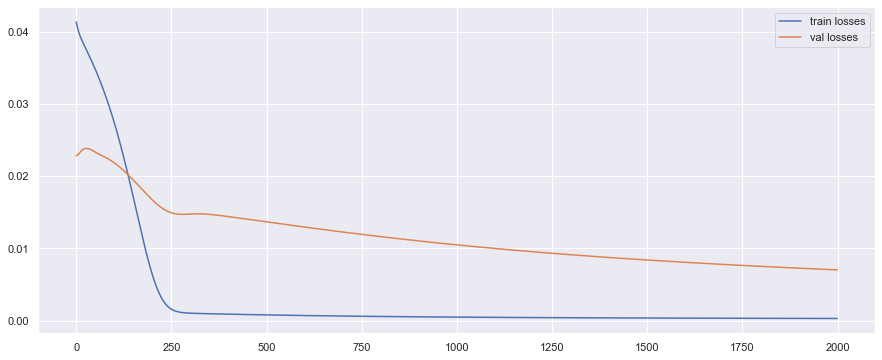

In [78]:
plt.plot(train_losses,label = 'train losses')
plt.plot(val_losses, label = 'val losses')
plt.legend()
plt.show()

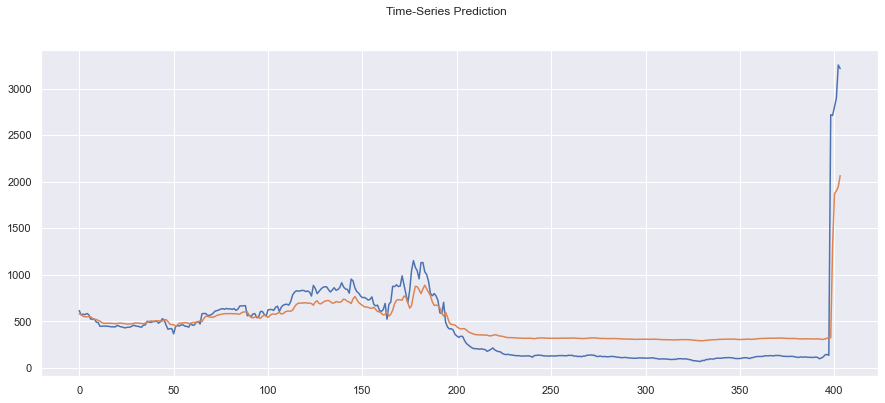

In [79]:
lstm.eval()
test_predict = lstm(testX)

data_predict = test_predict.data.numpy()
dataY_plot = testY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.plot(dataY_plot, label='data test')
plt.plot(data_predict, label = 'data predict')
plt.suptitle('Time-Series Prediction')
plt.legend()
plt.show()
# plt.axvline(x=200, c='r', linestyle='--')


# GRU

In [80]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_prob):
        super(GRU, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.num_layers = num_layers
        self.hidden_size = hidden_size

        # GRU layers
        self.gru = nn.GRU(
            input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [81]:
call_seed()
train_losses = []
val_losses = []
num_epochs = 2000
learning_rate = 0.001

input_size = 1
hidden_size = 2
num_layers = 2


gru = GRU(input_size, hidden_size, num_layers,0.1)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(gru.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = gru(trainX)
    optimizer.zero_grad() #gradiente azzerato sennò usi quello dell'iterazione prima.
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    train_losses.append(loss.item())
    
    loss.backward() #backpropagation
    
    optimizer.step() #applica il gradiente 
    with torch.no_grad(): #facciamo un validation sul test, ma qui la rete NON impara!
        outputs_val = gru(testX)
        loss_val = criterion(outputs_val,testY)
        val_losses.append(loss_val.item())
    if epoch %100 == 0 :
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
        print("Epoch: %d, loss_val: %1.5f" % (epoch, loss_val.item()))

Epoch: 0, loss: 0.39925
Epoch: 0, loss_val: 0.23285
Epoch: 100, loss: 0.12686
Epoch: 100, loss_val: 0.07023
Epoch: 200, loss: 0.04966
Epoch: 200, loss_val: 0.02756
Epoch: 300, loss: 0.04193
Epoch: 300, loss_val: 0.02412
Epoch: 400, loss: 0.04023
Epoch: 400, loss_val: 0.02400
Epoch: 500, loss: 0.03876
Epoch: 500, loss_val: 0.02430
Epoch: 600, loss: 0.03642
Epoch: 600, loss_val: 0.02491
Epoch: 700, loss: 0.03079
Epoch: 700, loss_val: 0.02774
Epoch: 800, loss: 0.02182
Epoch: 800, loss_val: 0.03649
Epoch: 900, loss: 0.01549
Epoch: 900, loss_val: 0.04989
Epoch: 1000, loss: 0.01105
Epoch: 1000, loss_val: 0.05606
Epoch: 1100, loss: 0.00785
Epoch: 1100, loss_val: 0.05541
Epoch: 1200, loss: 0.00493
Epoch: 1200, loss_val: 0.05547
Epoch: 1300, loss: 0.00354
Epoch: 1300, loss_val: 0.05208
Epoch: 1400, loss: 0.00291
Epoch: 1400, loss_val: 0.05025
Epoch: 1500, loss: 0.00248
Epoch: 1500, loss_val: 0.04685
Epoch: 1600, loss: 0.00211
Epoch: 1600, loss_val: 0.04313
Epoch: 1700, loss: 0.00233
Epoch: 1700

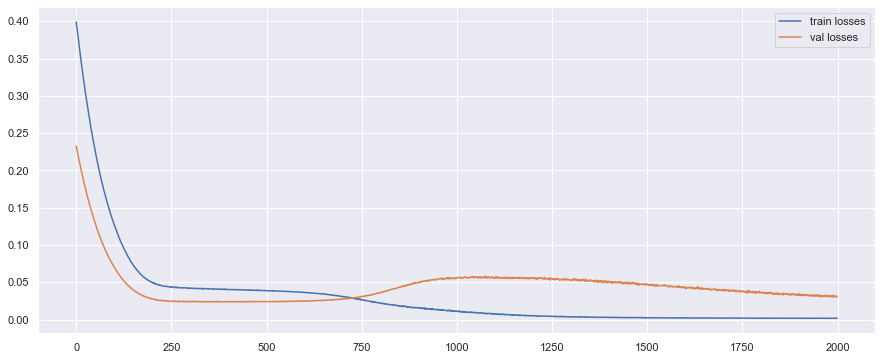

In [82]:
plt.plot(train_losses,label='train losses')
plt.plot(val_losses, label = 'val losses')
plt.legend()
plt.show()

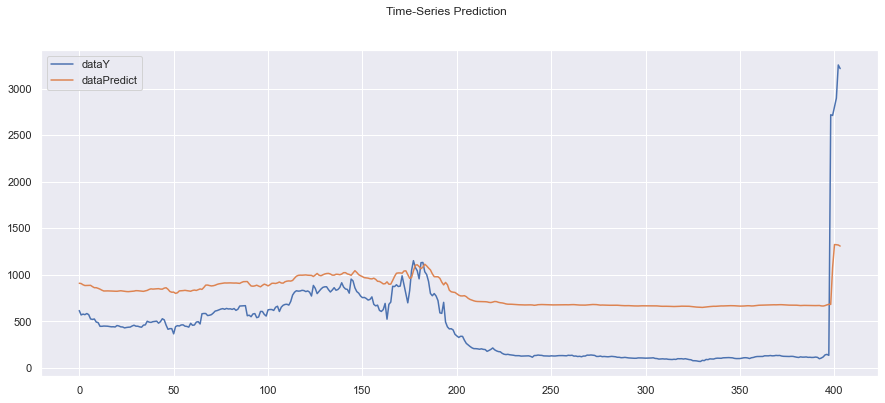

In [84]:
gru.eval()
test_predict = gru(testX)

data_predict = test_predict.data.numpy()
dataY_plot = testY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.plot(dataY_plot,label= 'dataY')
plt.plot(data_predict, label='dataPredict')
plt.suptitle('Time-Series Prediction')
plt.legend()
plt.show()
# plt.axvline(x=200, c='r', linestyle='--')


# now let's make money...or go bankrupt